## 1. Load Model
Load the CNN model with trained weight and bias from the .pt file.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# CNN class
class CNN(nn.Module):
     # Initialization
    def __init__(self):
        super (CNN, self).__init__()
        
        self.conv1_out_np = np.zeros((1, 3, 24, 24))
        self.mp1_out_np = np.zeros((1, 3, 12, 12))
        self.conv2_out_np = np.zeros((1, 3, 8, 8))
        self.mp2_out_np = np.zeros((1, 3, 4, 4))
        self.fc_in_np = np.zeros((1, 48))
        self.fc_out_np = np.zeros((1, 10))
        
        # 1st Convolution Layer
        # Image Input Shape -> (28, 28, 1)
        # Convolution Layer -> (24, 24, 3)
        # Pooling Max Layer -> (12, 12, 3)
        self.conv1 = nn.Conv2d(1, 3, kernel_size=5)
        
        # 2nd Convolution Layer
        # Image Input Shape -> (12, 12, 3)
        # Convolution Layer -> (8, 8, 3)
        # pooling Max Layer -> (4, 4, 3)
        self.conv2 = nn.Conv2d(3, 3, kernel_size=5)
        
        # Max Pooling Layer
        self.mp = nn.MaxPool2d(2)
        
        # Fully Connected Layer
        # Num of Weight = 480
        self.fc_1 = nn.Linear(48, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        
        # Layer Integration
        x = self.conv1(x)
        self.conv1_out_np = x.detach().numpy()
        
        x = F.relu(self.mp(x))
        self.mp1_out_np = x.detach().numpy()

        x = self.conv2(x)
        self.conv2_out_np = x.detach().numpy()
        
        x = F.relu(self.mp(x))
        self.mp2_out_np = x.detach().numpy()
        
        # Flatten Layer
        x = x.view(in_size, -1)
        self.fc_in_np = x.detach().numpy()
        
        # Fully Connected Layer
        x = self.fc_1(x)
        self.fc_out_np = x.detach().numpy()
        
        return F.log_softmax(x)

In [4]:
# Load model
model = torch.load("/home/ubuntu/workspace/cnn_mnist.pt", weights_only=False)
model.eval()
print(model)

CNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=48, out_features=10, bias=True)
)


## 2. Testing using Bitmap Image in SW
Test the model (SW) to classify a digit from .bmp image.

In [5]:
import re
import base64
import io
from PIL import Image
from matplotlib import pyplot

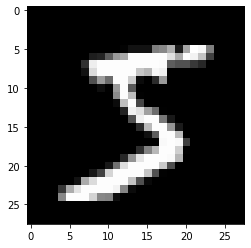

In [6]:
# Get bitmap data
img = Image.open("/home/ubuntu/workspace/bmp/train_0.bmp", "r")
np_img = np.array(img)
pyplot.imshow(np_img, cmap=pyplot.get_cmap('gray'))

In [ ]:
# Prepare data input
np_img_re_sw = np.reshape(np_img, (1,1,28,28))
data = Variable(torch.tensor((np_img_re_sw / 255), dtype = torch.float32))

In [8]:
# Output of feedforwarding
output = model(data)
pred = output.data.max(1, keepdim=True)[1]
print('Predicted output: ' + ', '.join(map(str, pred.flatten().tolist())))

Predicted output: 5


In [9]:
from time import time

In [10]:
# Calculate computation time for SW based CNN
t1 = time()
output = model(data)
t2 = time()
t_diff_sw = t2 - t1
print('Time used for SW CNN: {}s'.format(t_diff_sw))

Time used for SW CNN: 0.015293598175048828s


## 3. Program Bitstream
Program the bitstream to the FPGA.

In [11]:
from pynq import Overlay
from pynq import MMIO
from pynq import allocate

In [12]:
# Program bitstream to FPGA
overlay = Overlay('/home/ubuntu/workspace/cnn_mnist.bit')

# Access to AXI DMA
dma = overlay.axi_dma_0
dma_send = overlay.axi_dma_0.sendchannel
dma_recv = overlay.axi_dma_0.recvchannel

# Allocate physical memory
input_buffer = allocate(shape=(784,), dtype=np.uint8)
output_buffer = allocate(shape=(1,), dtype=np.uint8)

## 4. Testing using Bitmap Image in HW
Test the HW accelerator to classify a digit from .bmp image.

In [13]:
# Write input to physical memory
np_img_re_hw = np.reshape(np_img, (1,1,1,784))
for i in range(784):
    input_buffer[i] = np_img_re_hw[0][0][0][i]

In [14]:
# Do AXI DMA transfer
dma_send.transfer(input_buffer)
dma_recv.transfer(output_buffer)
print("Predicted output: %d" % (output_buffer[0]))

Predicted output: 5


In [15]:
# Calculate computation time for HW accelerator CNN
t1 = time()
dma_send.transfer(input_buffer)
dma_recv.transfer(output_buffer)
t2 = time()
t_diff_hw = t2 - t1
print('Time used for HW CNN: {}s'.format(t_diff_hw))

Time used for HW CNN: 0.0009090900421142578s


## 5. Evaluation
Calculate the speedup factor for the HW accelerator.

In [16]:
print('Hardware acceleration speed up: {:.1f}x'.format(t_diff_sw/t_diff_hw))

Hardware acceleration speed up: 16.8x
